### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
# s3_path = 'nneehal/DATA/odata/m6_knn_no_cluster_only_latent'
# data_path = '../temp'

# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

In [5]:
%%time
p = '../temp/odata_knn_h/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 187 ms, sys: 148 ms, total: 335 ms
Wall time: 358 ms


In [6]:
### Optional(filter registrations after  a particular month and before a particular month)

In [7]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [8]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [9]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [10]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [11]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [12]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 14.2 s, sys: 65.9 ms, total: 14.3 s
Wall time: 14.3 s


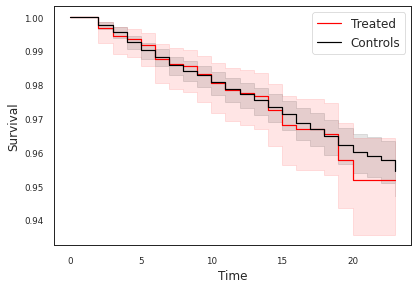

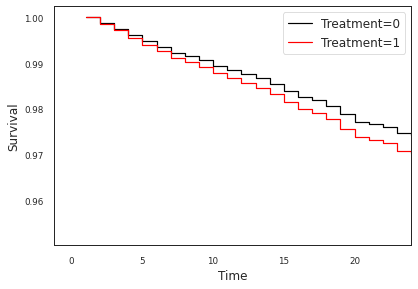

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [14]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        0.243008  0.622042  0.684916

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      0.893           0.375        2.382    0.017
Gender                   0.511           0.137        3.726    0.000
Total Cost               0.186           0.095        1.952    0.051
Tobacco use              0.065           0.207        0.313    0.754
Obesity                  0.567           0.137        4.152    0.000
Hypertension             0.211           0.144        1.463    0.144
Hypothyroid             -0.168           0.212       -0.794    0.427
Disease Count            0.884           0.574        1.541    0.123
Line of Bussiness       -0.470           0.171       -2.753    0.006
Treatment                0.141           0.154        0.911    0.362

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 14.2 s, sys: 56.7 ms, total: 14.3 s
Wall time: 14.3 s


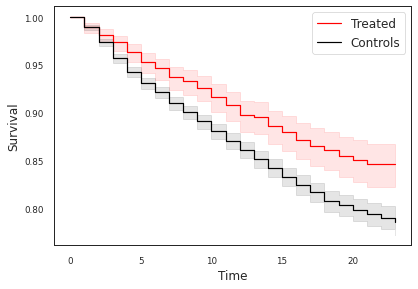

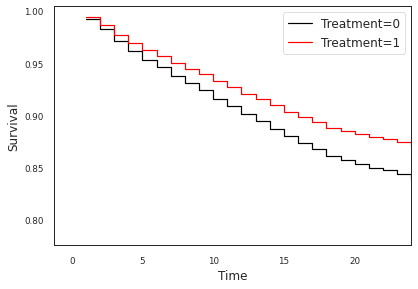

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [19]:
lrsumm

test_statistic         p   -log2(p)
ER        19.21619  0.000012  16.386597

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.399           0.160       -8.721    0.000
Gender                  -0.094           0.071       -1.321    0.187
Total Cost               0.131           0.042        3.127    0.002
Tobacco use              0.186           0.083        2.233    0.026
Obesity                  0.007           0.059        0.126    0.900
Hypertension             0.150           0.067        2.228    0.026
Hypothyroid             -0.190           0.095       -2.004    0.045
Disease Count            2.426           0.241       10.047    0.000
Line of Bussiness       -0.791           0.067      -11.795    0.000
Treatment               -0.233           0.079       -2.957    0.003

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 14.4 s, sys: 26.3 ms, total: 14.4 s
Wall time: 14.4 s


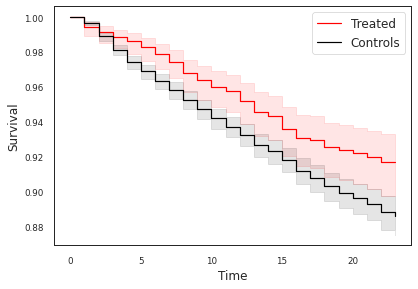

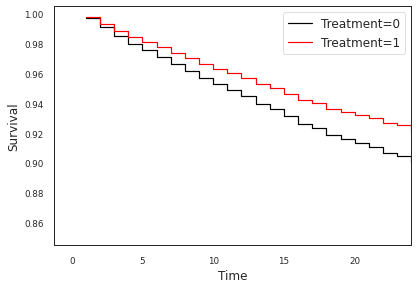

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [24]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7f578ce2eda0>>

In [25]:
lrsumm

test_statistic         p  -log2(p)
IP        7.259837  0.007051  7.147881

In [26]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.876           0.221       -8.496    0.000
Gender                   0.074           0.095        0.772    0.440
Total Cost               0.169           0.059        2.836    0.005
Tobacco use              0.159           0.114        1.390    0.164
Obesity                 -0.303           0.082       -3.694    0.000
Hypertension             0.126           0.093        1.347    0.178
Hypothyroid             -0.171           0.131       -1.306    0.192
Disease Count            3.270           0.321       10.179    0.000
Line of Bussiness       -0.277           0.099       -2.785    0.005
Treatment               -0.252           0.108       -2.332    0.020

### Acute Care IP OR ER

In [27]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [28]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 14.3 s, sys: 23.5 ms, total: 14.3 s
Wall time: 14.3 s


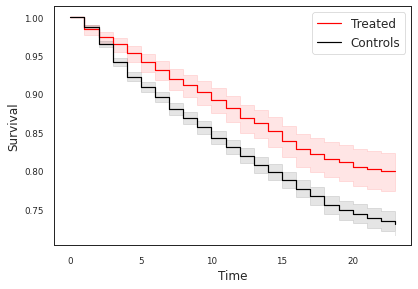

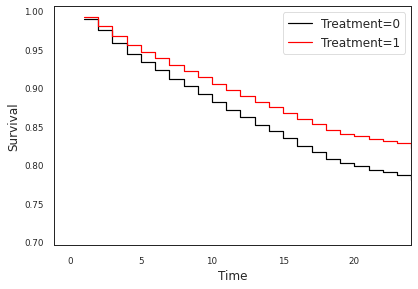

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [30]:
lrsumm

test_statistic         p   -log2(p)
Acute       21.397619  0.000004  18.031487

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.505           0.141      -10.651    0.000
Gender                  -0.060           0.062       -0.971    0.332
Total Cost               0.144           0.037        3.910    0.000
Tobacco use              0.134           0.075        1.779    0.075
Obesity                 -0.076           0.052       -1.463    0.143
Hypertension             0.144           0.059        2.434    0.015
Hypothyroid             -0.144           0.083       -1.738    0.082
Disease Count            2.613           0.219       11.938    0.000
Line of Bussiness       -0.658           0.061      -10.843    0.000
Treatment               -0.237           0.069       -3.456    0.001

### Load all Log Rank Sums in a matrix

In [32]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [33]:
df2

logRank statistic   p-value  RMST difference
Diabetes                   0.243008  0.622042        -0.031623
Emergency Visits          19.216190  0.000012         0.853740
Inpatient Vistis           7.259837  0.007051         0.410533
Acute Care                21.397619  0.000004         1.047119